# Blank Factory

## Subroutines

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cmath import pi,acos,exp,sqrt
def plotArc(ax,P0,n0,l,da,*args,tol=0.001,**kwargs):
  if l==0:
    return
  x=np.linspace(0,l,max(2,int(abs(6*(da/(2*pi)))),int(l//(2*abs(2*l/da*tol)**0.5)+1))if (da!=0) and (l!=0) else 2)
  phi2=x/l*da/2
  p=P0+x*np.sinc(phi2/pi)*n0*np.exp(1j*phi2)
  ax.plot(p.real,p.imag,*args,**kwargs)
    
def plotArcchain(ax,P0,n0,arcs,*args,**kwargs):
    p=P0
    n=n0
    for l,da in arcs:
        plotArc(ax,p,n,l,da,*args,**kwargs)
        p+=l*np.sinc(da/(2*pi))*n*exp(1j*da/2)
        n*=exp(1j*da)
        
def calcTangent(c1,r1,c2,r2):
    c2_c1=(c2-c1)
    lcc=abs(c2_c1) 
    ec2_c1=c2_c1/lcc
    cosphi=((r1+r2)/lcc)
    phi=-cosphi+1j*(1-cosphi**2)**0.5
    t1=c1-r1*ec2_c1*phi
    t2=c2+r2*ec2_c1*phi
    return [t1,t2]
    
def reduce(function, iterable, initializer=None):
    it = iter(iterable)
    if initializer is None:
        value = next(it)
    else:
        value = initializer
    for element in it:
        value = function(value, element)
    return value
    
def pipe(*args): #reverses the order of chained function calls: f3(f2(f1(x))) => pipe(x,f1,f2,f3)
#    from functools import reduce
    if args[0]==None:
        return lambda X:reduce(lambda x,f:f(x),args[1:],X)
    else:
        return reduce(lambda x,f:f(x),args)
      
def iterize(f):
    def wrapper(t,/,*args,**kwargs):
        return (f(t_,*args,**kwargs) for t_ in t) if hasattr(t,'__next__') else f(t,*args,**kwargs)
    wrapper.__name__='iterized_'+f.__name__
    return wrapper

In [2]:
from cmath import sin
from time import perf_counter
p=pipe(None,iterize(sin))
t1=perf_counter()
x=list(p(iter(range(1000))))
t2=perf_counter()
print(f'{t2-t1=}, {len(x)=}')

t2-t1=0.0003067918587476015, len(x)=1000


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign,inf

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLength(Segs):
    return sum(l for l,*_ in Segs)

def SegmentsArea(Segs):
  nSegs=len(Segs)
  dl,dang,*opts=np.array(Segs).transpose()
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return area

def InterpSegments(Segs,t,p0=0.+0.j,a0=0+1j,scale=1.0,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array([(l,a) for l,a,*_ in Segs]).transpose()
  L=np.cumsum(np.insert(dl,0,0.0))
  ang_=np.cumsum(np.insert(dang,0,0.0))
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  if not hasattr(t,'__getitem__'): #not an array
    t=np.array([t]) #convert to array
  else:
    if t.shape==(): #no dimensions
      t=np.array([t])
    else:
      t=np.array(t)
  T=t.astype(int)
#  t=t-T
  if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
    pr,ar=np.zeros((len(t),),dtype=complex), np.ones((len(t),),dtype=complex) # closed loop. No translation/rotation necessary for t>1
  else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
    def rotateSecant(v,beta,T):
      beta2=beta/2
      rot2=exp(1j*beta2)
      uniqueT,inverseIndex=np.unique(T,return_inverse=True) #don't re-calculate for identical values of T
      p=(v*rot2**(uniqueT-1)/np.sinc(beta2/np.pi) * uniqueT * np.sinc(uniqueT*beta2/np.pi))[inverseIndex]
      a=(rot2**(2*uniqueT))[inverseIndex]
      return p,a
    pr,ar=rotateSecant(pSeg[-1]*a0,ang_[-1],T)
  pr+=p0
  ar*=a0
  l=L/L[-1]
  Xx=np.interp(t-T,l,range(len(l)))
  X=np.maximum(0,np.minimum(Xx.astype(int),len(dang)-1)) #segment index
  x=Xx-X#within seggment
  p=pSeg[X] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  p=p*ar+pr
  a=ang[X]*np.exp(1j*dang[X]*x)*ar
  if len(p)==1:
      p=p[0] #convert array to single value if argument was a single value
      a=a[0]
  return p,a,L[-1]*t,X

def Segments2Complex(Segs,p0=0.+0.j,scale=1.0,a0=0+1j,tol=0.05,offs=0,loops=1,return_start=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  L=0
  if return_start:
      yield p,a,L,-1 #assuming closed loop: start-point = end-point
  loopcount=0
  while (loops==None) or (loops==inf) or (loopcount<loops):
      loopcount+=1
      for X,(l,da,*_) in enumerate(Segs):
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for i in range(n):
          L+=l/n
          p+=v
          yield p,a,L,X
          v*=dda
          a*=dda

In [4]:
def ISO_thread(z=None,/,phi=0.0,*,Pitch,External=False):
    tan60=3**0.5
    cos60=0.5
    sin60=tan60*cos60
    Pitch2=Pitch/2
    H=(Pitch2)*tan60
    flank_start=Pitch2/8
    r_maj=flank_start/sin60
    r_maj2=r_maj**2
    c_maj=-flank_start/tan60
    r_min=2*r_maj    
    r_min2=r_min**2
    c_min=-5/8*H+Pitch2/4/tan60
    flank_end=(3/4)*Pitch2
    if External:
        def ISO_thread_(z,/,phi=phi,*_,**__):
            dz=abs((z-phi*Pitch+Pitch2)%Pitch-Pitch2)#use symmetries
            if dz<flank_start:
                return 0.0
            if dz<=flank_end:
                return -tan60*(dz-flank_start)
            return  (c_min-(r_min2-(Pitch2-dz)**2)**0.5)
    else:# internal thread
        def ISO_thread_(z,/,phi=phi,*_,**__):
            dz=abs((z-phi*Pitch+Pitch2)%Pitch-Pitch2)#use symmetries
            if dz<flank_start:
                return c_maj+(r_maj2-dz**2)**0.5
            if dz<=flank_end:
                return -tan60*(dz-flank_start)
            return -5/8*H
    return ISO_thread_(z) if z!= None else ISO_thread_


### linear mesh

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy
import cmath  
    
%matplotlib notebook

linearData=dict(l1=0.15, r1=0.1, l2=0.15, r2=0.1,strands=5)
def update_linear_plot(l1,r1,l2,r2,strands,**kwargs):
  output1.clear_output(wait=True)
  with output1:
    %matplotlib inline
    fig=plt.figure(figsize=(3,3)) 
    ax=fig.add_subplot(1,1,1)  
    plotArcchain(ax,0+0j,1+0j,((l1,0),(r1*2*pi,2*pi)))
    c1=l1+1j*r1
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,1+1j,-1+0j,((l2,0),(r2*2*pi,2*pi)))
    c2=(1-l2)+1j*(1-r2)
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output2.clear_output(wait=True)
  with output2:
    fig=plt.figure(figsize=(12,3 )) 
    ax=fig.add_subplot(1,1,1)  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi
    arcs=[(l1,0),(r1*phitan,phitan),(ltan,0),(r2*phitan,-phitan),(l2,0)]
    arcs=(arcs+arcs[-1::-1])*2
    for i in range(strands):
      p0=2*i/strands+0j
      n0=1+0j
      plotArcchain(ax,p0,n0,arcs,c=['r','g','b','y','k'][i])
    ax.set_xlim(0,4)
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output3.clear_output(wait=True)
  with output3:
    print(f'{l1=:0.3f}, {r1=:0.3f}, {l2=:0.3f}, {r2=:0.3f}, {strands=:d}')
    print(f'mesh={arcs[:5]}')
  plt.close()

from ipywidgets import widgets,HBox,VBox
output1=widgets.Output() 
output2=widgets.Output()
output3=widgets.Output()
def handle_linearChange(msg):
  linearData[msg['owner'].description] = msg['new']
  update_linear_plot(**linearData)

widgetList1=dict()

for key,value in linearData.items():
    if type(value)==float:
      widgetList1[key]=widgets.FloatSlider(description=key,
            min=0.0,max=1.0,value=value,step=0.01,continuous_update=False, orientation='horizontal',layout={'width':'5in'},
            readout_format='0.3f')
    else:
      widgetList1[key]=widgets.BoundedIntText(description=key,
            min=1,max=5,value=value,step=1,continuous_update=False,layout={'width':'1.5in'},
            readout_format='d')
    widgetList1[key].observe(handle_linearChange,'value')

Layout1=VBox(
        [
        HBox([VBox([widgets.HTML(value="<h2>Parameters</h2>"),widgetList1['l1'], widgetList1['r1'],widgetList1['l2'],widgetList1['r2'],widgetList1['strands']],), output1,],),
        output2,
        output3
        ])
update_linear_plot(**linearData);

### circular mesh

In [6]:
from cmath import pi
circularData=dict(r_rim= 10.000, r_hub=3.500, n_spokes=13, n_strands=5,
                  phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.050, r_fillet_hub=0.200,)

deg=pi/180.0               

def update_circular_plot(*args,r_rim, r_hub, n_spokes, phi_rim, r_fillet_rim, phi_hub, r_fillet_hub, n_strands,**kwargs):#all arguments are required keyword arguments. additional arguments are allowed
  output4.clear_output(wait=True)
  phi_tot=2*pi*n_strands
  phi_spoke2=phi_tot/(2*n_spokes)
  l1,r1,l2,r2=phi_rim*phi_spoke2*r_rim,r_fillet_rim*phi_spoke2*r_rim,phi_hub*phi_spoke2*r_hub,r_fillet_hub*phi_spoke2*r_hub
  with output4:
    %matplotlib inline
    fig=plt.figure(figsize=(4,4)) 
    ax=fig.add_subplot(1,1,1)  
    if phi_spoke2>60*deg:
        ax.plot(0,0,'+')
    for phi in np.exp(1j*np.linspace(0,phi_spoke2,2)):
      p1=-1.0j*(r_hub-0.2*(r_rim-r_hub))*phi
      p2=-1.0j*(r_rim+0.2*(r_rim-r_hub))*phi
      ax.plot((p1.real,p2.real),(p1.imag,p2.imag),'k-.',lw=1)
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    plotArcchain(ax,0-1j*r_rim,1+0j,((l1,phi_rim*phi_spoke2),(r1*2*pi,2*pi)))
    c1=(0-1j*(r_rim-r1))*exp(1j*phi_rim*phi_spoke2)
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,(0-1j*r_hub)*exp(1j*phi_spoke2),(-1+0j)*exp(1j*phi_spoke2),((l2,-phi_hub*phi_spoke2),(r2*2*pi,2*pi)))
    c2=(0-1j*(r_hub+r2))*exp(1j*((1-phi_hub)*phi_spoke2))
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi #counter-clockwise 0-360deg
    arcs=[(l1,phi_rim*phi_spoke2),(r1*(phitan-phi_rim*phi_spoke2),phitan-phi_rim*phi_spoke2),(ltan,0),(r2*(phitan-((1-phi_hub)*phi_spoke2)),-phitan+((1-phi_hub)*phi_spoke2)),(l2,phi_hub*phi_spoke2)]
    arcs=(arcs+arcs[-1::-1])# add mirrored arc sequence
    for i in range(n_strands):
        dphi=2*phi_spoke2/n_strands
        phi=exp(-1j*dphi*(i+1))
        plotArcchain(ax,(-1j*r_rim)*phi,(1+0j)*phi,arcs*2,c='lightgray',zorder=-1)
    if n_strands<2:
      for r in [r_hub,r_rim]:
        p=-1j*r*np.exp(1j*np.linspace(0,phi_spoke2,25))
        ax.plot(p.real,p.imag,c='lightgray',lw=1,zorder=-1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output5.clear_output(wait=True)
  with output5:
    fig=plt.figure(figsize=(6,6)) 
    ax=fig.add_subplot(1,1,1)  
    p0=0-1j*r_rim
    n0=1+0j
    plotArcchain(ax,p0,n0,arcs*n_spokes,c='b')
    ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]],[ylim[0],ylim[0],ylim[1],ylim[1],ylim[0]],'--',c='gray',lw=1)
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output6.clear_output(wait=True)
  with output6:
    from math import gcd
    if  gcd(n_strands,n_spokes)!=1:
        print('\x1b[31m'+f'n_strands and n_spokes are not coprime: {gcd(n_strands,n_spokes)=} (should be 1)'+'\x1b[0m')
    print(f'{r_rim=: 0.3f}, {r_hub=:0.3f}, {n_spokes=:d}, {n_strands=:d},')
    print(f'{phi_rim=:0.3f}, {r_fillet_rim=:0.3f}, {phi_hub=:0.3f}, {r_fillet_hub=:0.3f},')
    print()
    print(f'mesh={arcs[:5]}')
    
  plt.close()

from ipywidgets import widgets,HBox,VBox
output4=widgets.Output() 
output5=widgets.Output()
output6=widgets.Output()

def handle_circularChange(msg):
  circularData[msg['owner'].description] = msg['new']
  update_circular_plot(**circularData)
    
widgetList2={}
for key,value in circularData.items():
    if type(value)==int:
        widgetList2[key]=widgets.IntText(description=key, value=value,layout={'width':'1.5in'}, readout_format='d')
    elif type(value)==float:
        widgetList2[key]=widgets.FloatText(description=key, value=value,layout={'width':'1.5in'}, readout_format='0.3f')
    else: print(f'need to add widget for {key=}, {type(value)=}');continue
    widgetList2[key].observe(handle_circularChange,'value')

Layout2=VBox(
        [HBox([
        VBox([HBox([VBox([widgetList2['r_rim'],widgetList2['r_hub'],widgetList2['n_spokes'],widgetList2['n_strands']],),VBox([widgetList2['phi_rim'], widgetList2['r_fillet_rim'],widgetList2['phi_hub'],widgetList2['r_fillet_hub'],]),],),
             output4]),
        output5,]),
        output6
        ])
update_circular_plot(**circularData);
plt.close()

In [48]:
from cmath import pi
import cmath
import math
from functools import partial
tripodData=dict(r_rim= 35.000, r_hub=31.000, n_spokes=63, n_strands=5,
                phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.160, r_fillet_hub=0.060,
                L=35.000, R1=11.000, R2=4.000, R3=8.000, R4=8.000, R5=26.000,
                sL=1.000, sR1=1.500, sR2=0.450, sR3=1.000, sR4=0.700, sR5=0.800,
                z_=0.0,h=8,w_chamfer=1.0,w_chamfer1=6.0,ew_factor=0.5,
                n_skirt=0,skirt_offset=1.0)

deg=pi/180.0               

def mesh_transformer(pz=None,/,*args,r_rim,r_hub,outline,p0o,n0o,outline_stretch,inline,p0i,n0i,inline_stretch,finline_offset=lambda *_:0.0,foutline_offset=lambda *_:0.0,**kwargs):
    unstretched_outline=np.cumsum([0.0]+[l for l,*_ in outline])
    unstretched_outline/=unstretched_outline[-1]
    stretched_outline=np.cumsum([0.0]+[l/s for (l,*_),s in zip(outline,outline_stretch)])
    stretched_outline/=stretched_outline[-1]
    unstretched_inline=np.cumsum([0.0]+[l for l,*_ in inline])
    unstretched_inline/=unstretched_inline[-1]
    stretched_inline=np.cumsum([0.0]+[l/s for (l,*_),s in zip(inline,inline_stretch)])
    stretched_inline/=stretched_inline[-1]
    def transform_mesh(pz,/):
      p=pz[0]
      #transform raw mesh to tripod shape: 
      T_mesh=(np.angle(p)/(2*pi))%1.0 #phase angle of mesh points [0..1[
      r_mesh=abs(p)#amplitude of mesh points
      pout,aout,Lout,*_=InterpSegments(outline,np.interp(T_mesh,stretched_outline,unstretched_outline),p0o,n0o)
      pout+=aout*1j*foutline_offset(pz[1],Lout)
      pin,ain,Lin,*_=InterpSegments(inline,np.interp(T_mesh,stretched_inline,unstretched_inline),p0i,n0i)   
      pin+=ain*1j*finline_offset(pz[1],Lin)
      p_transformed_point=pin+(pout-pin)*((r_mesh-r_hub)/(r_rim-r_hub)) #transform raw mesh to tripod shape
      pz[0]=p_transformed_point
      return pz
    return iterize(transform_mesh)(pz) if pz!=None else iterize(transform_mesh)
        
def calibrator(pz=None,/,*args,p_center=0.0+0.0j,r_ref,dr_offset=0.0,f_offset=None,dr_rigid=0.0,mesh_compression=2.0,ew_factor=None,**kwargs):
    import cmath
    r_rigid_max=r_ref+dr_rigid
    r_rigid_min=r_ref-dr_rigid
    def calibrate(p_z_ew,/):
        p=p_z_ew[0]
        dr=dr_offset
        if ew_factor!=None:
            dr+=p_z_ew[2]*ew_factor
        dp=p-p_center
        r=abs(dp)
        if f_offset==None:
            r_max=r_rigid_max+dr/2+abs(dr)*(0.5+1/(mesh_compression-1))
            r_min=r_rigid_min+dr/2-abs(dr)*(0.5+1/(mesh_compression-1))
            if (r>r_max) or (r<r_min): 
                return p_z_ew#return early if point is outside the affected zone
        phi=dp/r
        if f_offset!=None:
            dr+=f_offset(p_z_ew[1],(cmath.polar(phi)[1]/(2*pi))%1,r=r_ref)
            r_max=r_rigid_max+dr/2+abs(dr)*(0.5+1/(mesh_compression-1))
            r_min=r_rigid_min+dr/2-abs(dr)*(0.5+1/(mesh_compression-1))
            if (r>r_max) or (r<r_min): 
                return p_z_ew#return early if point is outside the affected zone
        if r_rigid_min < r <r_rigid_max: #just shift the point if it is in the rigid zone
            p_z_ew[0]+=dr*phi
            return p_z_ew
        if r>r_ref:#scale the amout of shift down to zero towards r_max
            x=(r_max-r)/(r_max-r_rigid_max)
            p_z_ew[0]=p_center+(r_max - x*(r_max - (dr+r_rigid_max)))*phi
            return p_z_ew
        else: #(r<=r_ref) scale the amount of shift down to zero towards r_min
            x=(r-r_min)/(r_rigid_min-r_min)
            p_z_ew[0]=p_center+(r_min + x*((dr+r_rigid_min)-r_min))*phi
            return p_z_ew
    return iterize(calibrate)(pz) if pz!=None else iterize(calibrate)

    
def rotor(pz=None,/,*args,center=0+0j,angle=None,phase=None,fphase=None,**kwargs):
    if fphase != None:
        def rotate(pz,/):
           pz[0]=center+(pz[0]-center)*fphase(pz[1],pz)
           return pz
    else: 
        if angle!=None:
            phase=1j**(angle*2/pi)#same as cmath.exp(1j*angle), but without cmath
        if phase == None:
            raise Exception("Argunent error in call to 'rotor': one of the arguments {phase|angle|fphase} is required") 
        def rotate(pz,/):
            pz[0]=center+(pz[0]-center)*phase
            return pz
    return iterize(rotate)(pz) if pz!=None else iterize(rotate)
        
def update_tripod_plot(*args,r_rim,r_hub,n_spokes,phi_rim, r_fillet_rim, phi_hub, r_fillet_hub,n_strands,L,R1,R2,R3,R4,R5,sL,sR1,sR2,sR3,sR4,sR5,h,w_chamfer,w_chamfer1,ew_factor,z_,n_skirt,skirt_offset,**kwargs):
  output7.clear_output(wait=True)
  phi_tot=2*pi*n_strands
  phi_spoke2=phi_tot/(2*n_spokes)
  l1,r1,l2,r2=phi_rim*phi_spoke2*r_rim,r_fillet_rim*phi_spoke2*r_rim,phi_hub*phi_spoke2*r_hub,r_fillet_hub*phi_spoke2*r_hub
  with output7:
    %matplotlib inline
    fig=plt.figure(figsize=(3.5,3.5)) 
    ax=fig.add_subplot(1,1,1)  
    if phi_spoke2>60*deg:
        ax.plot(0,0,'+')
    for phi in np.exp(1j*np.linspace(0,phi_spoke2,2)):
      p1=-1.0j*(r_hub-0.2*(r_rim-r_hub))*phi
      p2=-1.0j*(r_rim+0.2*(r_rim-r_hub))*phi
      ax.plot((p1.real,p2.real),(p1.imag,p2.imag),'k-.',lw=1)
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    plotArcchain(ax,0-1j*r_rim,1+0j,((l1,phi_rim*phi_spoke2),(r1*2*pi,2*pi)))
    c1=(0-1j*(r_rim-r1))*exp(1j*phi_rim*phi_spoke2)
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,(0-1j*r_hub)*exp(1j*phi_spoke2),(-1+0j)*exp(1j*phi_spoke2),((l2,-phi_hub*phi_spoke2),(r2*2*pi,2*pi)))
    c2=(0-1j*(r_hub+r2))*exp(1j*((1-phi_hub)*phi_spoke2))
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi #counter-clockwise 0-360deg
    arcs=[(l1,phi_rim*phi_spoke2),(r1*(phitan-phi_rim*phi_spoke2),phitan-phi_rim*phi_spoke2),(ltan,0),(r2*(phitan-((1-phi_hub)*phi_spoke2)),-phitan+((1-phi_hub)*phi_spoke2)),(l2,phi_hub*phi_spoke2)]
    arcs=(arcs+arcs[-1::-1])# add mirrored arc sequence
    for i in range(n_strands):
        dphi=2*phi_spoke2/n_strands
        phi=exp(-1j*dphi*(i+1))
        plotArcchain(ax,(-1j*r_rim)*phi,(1+0j)*phi,arcs*2,c='lightgray',zorder=-1)
    if n_strands<2:
      for r in [r_hub,r_rim]:
        p=-1j*r*np.exp(1j*np.linspace(0,phi_spoke2,25))
        ax.plot(p.real,p.imag,c='lightgray',lw=1,zorder=-1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output8.clear_output(wait=True)
  with output8:
    fig=plt.figure(figsize=(6,6)) 
    ax=fig.add_subplot(1,1,1) 
    p0o=L+R3+0j
    n0o=0+1j
    def sss(c,a,b): #triangle with 3 sides: return angle opposite first side 'c'
      cosgamma=(a**2+b**2-c**2)/(2*a*b)
      return math.acos(cosgamma)
    phi3=180*deg-sss(R5+R4,L,R3+R4)
    phi4=sss(L,R5+R4,R3+R4)
    phi5=60*deg-sss(R3+R4,L,R5+R4)
    outline=[(R3*phi3,phi3),(R4*phi4,-phi4),(R5*phi5,phi5)]
    outline+=outline[-1::-1]
    outline*=3
    plotArcchain(ax,p0o,n0o,outline,'b',lw=2,zorder=2)
#    ax.plot(0,0,'b:',lw=1.5,label='outside mesh surface')
    p0i=L+R2+0j
    n0i=0+1j
    inline=[(R2*180*deg,180*deg),(0,-90*deg),(L-R2-R1,0),(0,-90*deg),(R1*60*deg,60*deg)]
    inline+=inline[-1::-1]
    inline*=3
    plotArcchain(ax,p0i,n0i,inline,'b',lw=2,zorder=2)
    ax.plot(0,0,'b',lw=2,label='mesh outline')
    p_arrow=R1*cmath.exp(1j*45*deg)
    for text,c,r,offs,ang in [(r'$R_1$',0+0j,R1,-7.5,150*deg),(r'$R_2$',L*cmath.exp(1j*0*deg),R2,-9.5,45*deg),(r'$R_3$',L+0j,R3,8.0,60*deg),
                              (r'$R_4$',L+(R3+R4)*cmath.exp(1j*phi3),-R4,8.0,60*deg),(r'$R_5$',0+0j,R5,8.0,50*deg),
                              (r'$L$',L/2-10j,L/2,-L/2,0*deg),(r'$L$',L/2-10j,L/2,-L/2,180*deg)]:
        phi=cmath.exp(1j*ang)
        ptip=c+r*phi 
        ptext=c+(r+offs)*phi
        ax.annotate(text,xy=(ptip.real,ptip.imag),xycoords='data',
            xytext=(ptext.real, ptext.imag), textcoords='data',arrowprops=dict(facecolor='black', headwidth=6, headlength=10, width=0.25, shrink=0.0),
            horizontalalignment='center', verticalalignment='center',fontsize=14,backgroundcolor='w')
    for p1,p2 in [(0+5j,0-15j),(-5,5),(L+5j,L-15j),(L-5,L+5)]:
        ax.plot((p1.real,p2.real),(p1.imag,p2.imag),'k-.',lw=1) 
    p_mesh=list(zip(*((p.real,p.imag) for p,*_ in Segments2Complex(arcs,p0=r_rim+0.j,a0=0+1j,tol=0.01,return_start=True,loops=n_spokes))))
    ax.plot(p_mesh[0],p_mesh[1],'-',c='lightgray',label='raw mesh',zorder=-1) 
    ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]],[ylim[0],ylim[0],ylim[1],ylim[1],ylim[0]],'--',c='gray',lw=1,label='mesh detail')          
    outline_stretch=[sR3,sR4,sR5]
    outline_stretch+=outline_stretch[-1::-1]
    outline_stretch*=3
    inline_stretch=[sR2,1,sL,1,sR1]
    inline_stretch+=inline_stretch[-1::-1]
    inline_stretch*=3
    arc_ew=[1.0, 0.8, 0.7, 0.5, 0.5]#extrusion widths for rim...hub arc segments
    arc_ew=arc_ew+arc_ew[-1::-1]
    def terminator(pz=None,stopcondition=lambda *_:False):
        def checkterm(p,/):
            for x in p:
                if stopcondition(x):
                    return
                else:
                    yield x
            return
        def terminate(p,/):
            if hasattr(p,'__next__'):
                return checkterm(p)
            else:
                return p
                
        return terminate(pz) if pz!=None else terminate
        
        
    hl=0.2
    M8=ISO_thread(Pitch=1.25)
    transformed_mesh_points=list(zip(*pipe(
           Segments2Complex(arcs,p0=r_rim+0.j,a0=0+1j,tol=0.005,return_start=True,loops=n_spokes), 
           iterize(lambda pal:list((pal[0],z_,arc_ew[pal[3]],pal[1],))),
           terminator(stopcondition=lambda p_z_ew:p_z_ew[1]>(h+hl)),
           rotor(fphase=lambda z,*_:1j**(z/h/n_spokes*4)),
           mesh_transformer(r_rim=r_rim,r_hub=r_hub,
                                  outline=outline,p0o=p0o,n0o=n0o,outline_stretch=outline_stretch,
                                  foutline_offset=lambda z,*_,**__:max(0,w_chamfer-z,w_chamfer-(h-z)),
                                  inline=inline,p0i=p0i,n0i=n0i,inline_stretch=inline_stretch,),
           *(calibrator(p_center=L*1j**(i/3*4),r_ref=R2,f_offset=lambda z,*_,**__:max(0,(w_chamfer-z),w_chamfer-(h-z)))for i in range(3)),
           *(calibrator(p_center=L*1j**(i/3*4),r_ref=R2,f_offset=M8,ew_factor=ew_factor)for i in range(3)),
           calibrator(r_ref=R1,f_offset=lambda z,*_,**__:max(0,w_chamfer-z,w_chamfer1-1.0*(h-z)),ew_factor=ew_factor),
           iterize(lambda pz:(pz[0].real,pz[0].imag,*(pz[1:]))),
        )))
    ax.plot(transformed_mesh_points[0],transformed_mesh_points[1],'-',c='g',label='transformed mesh',zorder=1)
    if n_skirt>0:
      skirt=list(zip(*((p[0].real,p[0].imag) for offs in range(n_skirt) for p in Segments2Complex(outline,p0=L+R3+0.0j,a0=0+1j,tol=0.005,offs=0.5*offs+1,return_start=True) )))
      ax.plot(skirt[0],skirt[1],'c-',label='skirt')
#    T=np.arange(0.0,1.0-0.5/n_spokes,1.0/n_spokes)
#    pout,*_=InterpSegments(outline,np.interp(T,stretched_outline,unstretched_outline),p0o,n0o)
#    pin,*_=InterpSegments(inline,np.interp(T,stretched_inline,unstretched_inline),p0i,n0i) 
#    for p0,p1 in zip(pin,pout):
#      ax.plot((p0.real,p1.real),(p0.imag,p1.imag),'k-')

# NEMA 17 outline
    A,B,C,D,E,F=42.2,22,31,4,3,5
    p0=A/2+0j
    n0=0+1j
    NEMA=[(A/2-D,0),(D*45*deg,45*deg)]
    plotArcchain(ax,p0,n0,(NEMA+NEMA[-1::-1])*4,'--',c='gray',zorder=-1)
    ax.plot(0,0,'--',c='gray',label='NEMA 17 motor')
    n0=0+1j
    for p0,r in [(F/2+0j,F/2),(B/2+0j,B/2)]+[(x+E/2+1j*y,E/2) for x in [-C/2,C/2] for y in [-C/2,C/2]]:
      plotArc(ax,p0,n0,r*360*deg,360*deg,'--',c='gray',zorder=-1)
    ax.legend(loc='lower right')
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output9.clear_output(wait=True)
  with output9:
#    print(f'{R3+R4=}, {L=}, {R5+R4=}, {sss(R3+R3,L,R5+R4)/deg=}, {phi3/deg=},{phi4/deg=}, {phi5/deg=}, {R1=}')
#    print(f'{len(skirt)=}, {min(skirt[0])=:.2f}, {max(skirt[0])=:.2f}')
    from math import gcd
    if  gcd(n_strands,n_spokes)!=1:
        print('\x1b[31m'+f'n_strands and n_spokes are not coprime: {gcd(n_strands,n_spokes)=} (should be 1)'+'\x1b[0m')
    print(f'{r_rim=: 0.3f}, {r_hub=:0.3f}, {n_spokes=:d}, {n_strands=:d},')
    print(f'{phi_rim=:0.3f}, {r_fillet_rim=:0.3f}, {phi_hub=:0.3f}, {r_fillet_hub=:0.3f},')
    print(f'{L=:0.3f}, {R1=:0.3f}, {R2=:0.3f}, {R3=:0.3f}, {R4=:0.3f}, {R5=:0.3f},')
    print(f'{sL=:0.3f}, {sR1=:0.3f}, {sR2=:0.3f}, {sR3=:0.3f}, {sR4=:0.3f}, {sR5=:0.3f},')
    print()
    print(f'mesh={arcs[:5]}')
    
  plt.close()

from ipywidgets import widgets,HBox,VBox
output7=widgets.Output() 
output8=widgets.Output()
output9=widgets.Output()

def handle_change_tripod(msg):
  key=msg['owner'].description
  tripodData[key] = msg['new']
  if key=='h':
      widgetList3['z_'].max=tripodData[key]
  update_tripod_plot(**tripodData)
    
widgetList3={}
for key,value in tripodData.items():
    if type(value)==int:
        widgetList3[key]=widgets.IntText(description=key, value=value,layout={'width':'1.4in'}, readout_format='d')
    elif type(value)==float:
        widgetList3[key]=widgets.FloatText(description=key, value=value,layout={'width':'1.4in'}, readout_format='0.3f')
    else: print(f'need to add widget for {key=}, {type(value)=}');continue
key='z_'
widgetList3[key]=widgets.FloatSlider(description=key,
            min=0.0,max=tripodData['h'],value=tripodData[key],step=0.2,continuous_update=True, orientation='vertical',   
           readout_format='0.1f',layout={'height':'4.5in'})
for key in tripodData: widgetList3[key].observe(handle_change_tripod,'value')      
    
Layout3=VBox(
        [HBox([
        VBox([widgets.HTML(value='<h3 align=center>Mesh Parameters: </h3>'),
              HBox([VBox([widgetList3['r_rim'],widgetList3['r_hub'],widgetList3['n_spokes'],widgetList3['n_strands']],),VBox([widgetList3['phi_rim'], widgetList3['r_fillet_rim'],widgetList3['phi_hub'],widgetList3['r_fillet_hub'],]),],),
              output7,]),
        VBox([widgets.HTML(value='<h3 align=center>Geometry: </h3>'),widgetList3['L'], widgetList3['R1'],widgetList3['R2'],widgetList3['R3'],widgetList3['R4'],widgetList3['R5'],
              widgets.HTML(value='<h3 align=center>Mesh Stretch Factors:</h3>'),widgetList3['sL'], widgetList3['sR1'],widgetList3['sR2'],widgetList3['sR3'],widgetList3['sR4'],widgetList3['sR5'],],layout=dict(width='1.6in')),
        VBox([HBox([widgetList3['h'],widgetList3['w_chamfer'],widgetList3['w_chamfer1'],widgetList3['ew_factor']]),HBox([widgetList3['n_skirt'],widgetList3['skirt_offset']]),HBox([output8,widgetList3['z_']]),]),
        ]),
        output9
        ])

update_tripod_plot(**tripodData);
plt.close()

In [49]:
Layout=widgets.Tab([Layout1,Layout2,Layout3],titles=['Linear','Circular','Tripod'],selected_index=2)
Layout.set_title(0,'Linear')
Layout.set_title(1,'Circular')
Layout.set_title(2,'Tripod')

## Interactive Section

In [50]:
display(Layout);

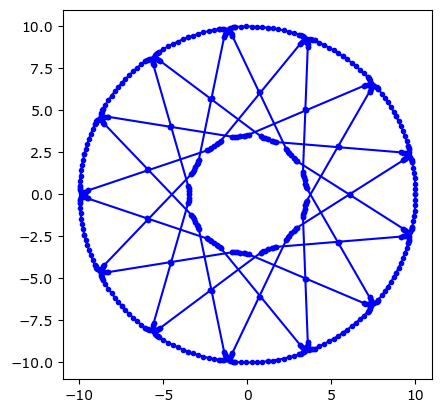

In [10]:
mesh=[(1.9332877868244882, 0.19332877868244883), (0.9388633012258815, 1.2950143724065095), (7.473407339055301, 0), (0.28796015806691877, -0.3404535276619185), (0.2114533516839284, 0.060415243338265257)]
mesh=mesh[:2]+[(mesh[2][0]/2,0)]*2+mesh[3:]#split the spoke in half
plotArcchain(plt.gca(),10,1j,(mesh+mesh[-1::-1])*13,'b.-')
plt.gca().set_aspect('equal') 

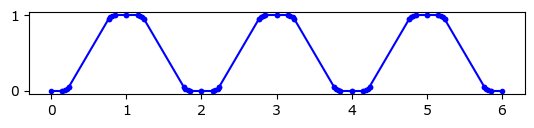

In [11]:
mesh=[(0.15, 0), (0.10412385590811431, 1.041238559081143), (1.0440306508910548, 0), (0.10412385590811431, -1.041238559081143), (0.15, 0)]
plotArcchain(plt.gca(),0,1,(mesh+mesh[-1::-1])*3,'b.-')
plt.gca().set_aspect('equal') 

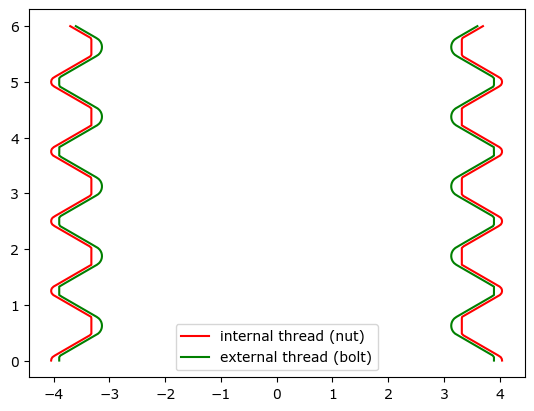

In [12]:
from matplotlib import pyplot as plt
import numpy as np
z=np.linspace(0,6,200)
M8_int=ISO_thread(Pitch=1.25)
M8_ext=ISO_thread(Pitch=1.25,External=True)
plt.plot([M8_int(z_)+4 for z_ in z],z,'r-',label='internal thread (nut)')
plt.plot([M8_ext(z_)-0.1+4 for z_ in z],z,'g-',label='external thread (bolt)')
plt.plot([-(M8_int(z_)+4) for z_ in z],z,'r-')
plt.plot([-(M8_ext(z_)-0.1+4) for z_ in z],z,'g-')

plt.legend()
plt.gca().set_aspect('equal')